In [2]:
import torch

## Images

In [9]:
import imageio
img_arr = imageio.imread('data/p1ch4/image-dog/bobby.jpg')
img_arr.shape

C:\Users\ncris\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(720, 1280, 3)

Now that we have a numpy array, can create a pytorch tensor. Need to change the layout, though as rgb components are last here but are first in torch stuff. Should be channel, height, width.

In [12]:
img = torch.from_numpy(img_arr)
img.shape

torch.Size([720, 1280, 3])

In [14]:
out = img.permute(2, 0, 1) # put 2nd dim first, 0th dim second, 1st dim third
out.shape # out just creates a view, does not make a new copy

torch.Size([3, 720, 1280])

To create a dataset of multiple images to use as input for NNs, store images in a batch in the first dim to obtain N, C, H, W tensors.

In [18]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8) # preallocating (could also use stack if not)

In [24]:
import os
data_dir = 'data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # in-case there's a 4th channel (or more) such as alpha
    batch[i] = img_t

C:\Users\ncris\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """


Normalize the data. NNs work best when input data from -1 to 1 or 0 to 1.

In [26]:
batch = batch.float()
batch /= 255.0 # simple rescaling of input data

To get mean 0, std 1

In [28]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean)/std # though in future should normalize over all training data

Example using volumetric data with (channel, depth, height, width)

In [29]:
dir_path = "data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%11/99 files (11.1%22/99 files (22.2%30/99 files (30.3%38/99 files (38.4%45/99 files (45.5%50/99 files (50.5%55/99 files (55.6%60/99 files (60.6%65/99 files (65.7%70/99 files (70.7%75/99 files (75.8%81/99 files (81.8%86/99 files (86.9%91/99 files (91.9%96/99 files (97.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/99  (12.130/99  (30.349/99  (49.567/99  (67.785/99  (85.999/99  (100.0%)


(99, 512, 512)

Get into specified form (4D)

In [36]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
vol.shape

torch.Size([1, 99, 512, 512])

## Tabular data
typically nonhomogenous--columns can have different types. Want to put into a tensor of floating point numbers. 

Look at wine data as an example. It's in a csv, so I'll use pandas (book uses numpy but I have enough exp with pandas that I'm gonna use that).

In [52]:
import pandas as pd
import numpy as np

In [53]:
wineq_pd = pd.read_csv('data/p1ch4/tabular-wine/winequality-white.csv', sep=';')
wineq = torch.from_numpy(wineq_pd.to_numpy(dtype=np.float32))

In [54]:
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

Now have a floating point tensor with all the columns including the last, which refers to the quality score.

In [61]:
data = wineq[:, :-1] # excluding score
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [62]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

Can either keep target as an integer vector or build a one-hot encoding of the scores 
(e.g., a score of 1 corresponds to 1,0,0,0,0,0,0,0,0,0  -- think unit vector).

**In general, use values directly when column contains continuous data or ordinal data where ordering is a priority. Use one-hot encoding or embedding when column contains categorical data or ordinal data where ordering is not a priority.**

one-hot encoding appropriate when scores are purely discrete (think utility--2 vs. 4 doesn't represent twice as happy)

In [72]:
target

tensor([6., 6., 6.,  ..., 6., 7., 6.])

In [73]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1).long(), 1.0) # for each row take idx corresp to element in target and set to 1.0 in target_onehot
# first arg is dim along which the following two args are specified, 
# second arg is a column tensor indicating idx of element to scatter,
# third arg is the elements/single scalar to scatter

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

More data prep

In [79]:
data_mean = torch.mean(data, dim=0)
data_mean # gets mean in every column

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [80]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [83]:
data_normalized = (data - data_mean)/torch.sqrt(data_var)

Finding thresholds

In [91]:
bad_indexes = target <= 3
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum(), bad_indexes.sum()/bad_indexes.shape[0]

(torch.Size([4898]), torch.bool, tensor(20), tensor(0.0041))

In [94]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

In [110]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)]
good_data = data[target >= 7]

# get means by col
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)
for i, c in enumerate(wineq_pd.columns[:-1]):
    print(f"{c}: {bad_mean[i]} {mid_mean[i]} {good_mean[i]}")

fixed acidity: 7.599999904632568 6.88687801361084 6.725142002105713
volatile acidity: 0.3332499861717224 0.28153225779533386 0.26534906029701233
citric acid: 0.3360000252723694 0.3364405333995819 0.3260565996170044
residual sugar: 6.392500400543213 6.70510721206665 5.261509418487549
chlorides: 0.05429999902844429 0.04784101992845535 0.038160376250743866
free sulfur dioxide: 53.32500076293945 35.42404556274414 34.550472259521484
total sulfur dioxide: 170.60000610351562 141.83302307128906 125.24528503417969
density: 0.9948840141296387 0.9944714307785034 0.9924120903015137
pH: 3.1875 3.180811882019043 3.215131998062134
sulphates: 0.47450000047683716 0.48706915974617004 0.5001415014266968
alcohol: 10.344999313354492 10.26479721069336 11.416023254394531


In [113]:
total_sulfur_thresh = 141.83
total_sulfur_data = data[:, 6]
predicted_vals = total_sulfur_data < total_sulfur_thresh
predicted_vals.shape, torch.sum(predicted_vals)

(torch.Size([4898]), tensor(2727))

In [116]:
actual_idxs = target > 5
actual_idxs.shape, actual_idxs.sum()

(torch.Size([4898]), tensor(3258))

See how much our predictions overlap with actual values.

In [124]:
n_matches = (predicted_vals & actual_idxs).sum()
n_matches, n_matches/predicted_vals.sum(), n_matches/actual_idxs.sum()

(tensor(2018), tensor(0.7400), tensor(0.6194))

So 74% of wines predicted to be high quality are actually high quality and ~62% of good wines are identified.

## Time Series
Using Washington DC bike-sharing system data. Need to change data from a flat 2D dataset to a 3D one.

In [132]:
bikes_pd = pd.read_csv("data/p1ch4/bike-sharing-dataset/hour-fixed.csv")
bikes_pd

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17516,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17517,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17518,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [131]:
bikes_pd.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [143]:
bikes_pd["dteday"] = pd.to_datetime(bikes_pd["dteday"]).dt.day # change date to the day of month

In [144]:
bikes = torch.from_numpy(bikes_pd.to_numpy(dtype=np.float32))

Want to have tensor of dim 3 and shape *N x C x L* (N collections of C sequences of length L). 

Want to have N = day, C = num cols, L = hours

In [145]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (1, 17520))

In [148]:
# view changes the way the tensor looks at the same data as contained in storage
daily_bikes = bikes.view(-1, 24, bikes.shape[1]) # -1 is a placeholder that will fill in the remaining indexes
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (24, 1, 17520))

In [149]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (24, 17520, 1))

Prep for training.

"Weather situation" variable is ordinal 1 (good) - 4 (very bad).

In [161]:
first_day = bikes[:24].long()
weather_onehot = torch.zeros(first_day.shape[0], 4)
first_day_weathsit = first_day[:, 9] - 1 # decrease because indices are 0 based but first value is 1
print(first_day_weathsit)
weather_onehot.scatter_(1, first_day_weathsit.unsqueeze(1), 1.0)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1])


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

Now concatenate along the column dim

In [167]:
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,
         16.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

Now use ```daily_bikes```

In [171]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [185]:
daily_weathsit = daily_bikes[:, 9, :].long() - 1
daily_weather_onehot.scatter_(1, daily_weathsit.unsqueeze(1), 1.0)
daily_cat = torch.cat((daily_bikes, daily_weather_onehot), 1)
daily_cat.shape

torch.Size([730, 21, 24])

Could also transform from ordinal to continuous.

In [ ]:
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - 1.0)/3.0 # rescale to [0, 1]

In [187]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = (daily_bikes[:, 10, :] - temp_min)/(temp_max - temp_min) # rescale to [0, 1]

In [ ]:
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = (daily_bikes[:, 10, :] - torch.mean(temp))/torch.std(temp) # rescale to mean 0, std 1

## Text
NLP using recurrent NNs (RNNs). Need to encode text in either characters or words as floats in a tensor.

In [190]:
with open('data/p1ch4/jane-austen/1342-0.txt', encoding='utf8') as f:
    text = f.read()

One-hot encoding characters. Using ASCII here because there shouldn't be anything crazy but UTF-8, UTF-16, UTF-32 common as well.

In [191]:
lines = text.split('\n')
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

In [192]:
letter_t = torch.zeros(len(line), 128) # 128 chars hardcoded
letter_t.shape

torch.Size([70, 128])

For each char (row), set a 1 in the column where the corresponding char lies.

In [193]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0 # ord returns unicode from given char
    letter_t[i][letter_index] = 1

One-hot encoding words.

First split into words and clean.

In [195]:
def clean_words(input_str):
    punct = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n', ' ').split()
    word_list = [word.strip(punct) for word in word_list]
    return word_list

words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

Now create a dict with an idx (value) corresp to each word (key) in the text.

In [197]:
word_list = sorted(set(clean_words(text)))
word2index_dict = {word: i for (i, word) in enumerate(word_list)}
len(word2index_dict), word2index_dict['impossible']

(7261, 3394)

In [200]:
word_t = torch.zeros(len(words_in_line), len(word2index_dict))
word_t.shape

torch.Size([11, 7261])

In [212]:
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i, word_index] = 1
    print('{:2} {:4} {}'.format(i, word_index, word))

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him


Use vectors of floating-point numbers to represent words. Find a mapping to do so (called embedding). Similar words will map to similar regions in embedding space.

Can also use embeddings for other categorical data--in general, lessons from text can be applied to categorical data.

## Exercises
1.

In [215]:
img_straw = imageio.imread('data/p1ch4/rgb-images/strawberries.jpg')
img_apple = imageio.imread('data/p1ch4/rgb-images/apples.jpg')
img_blueb = imageio.imread('data/p1ch4/rgb-images/blueberries.jpg')

C:\Users\ncris\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\ncris\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
C:\Users\ncris\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v

In [230]:
img_straw_t = torch.from_numpy(img_straw).permute(2, 0, 1).float()
img_apple_t = torch.from_numpy(img_apple).permute(2, 0, 1).float()
img_blueb_t = torch.from_numpy(img_blueb).permute(2, 0, 1).float()
img_straw_t.shape, img_apple_t.shape, img_blueb_t.shape

(torch.Size([3, 2109, 3124]),
 torch.Size([3, 900, 1200]),
 torch.Size([3, 728, 1296]))

Can also use PIL image

In [238]:
from PIL import Image
img_straw = Image.open('data/p1ch4/rgb-images/strawberries.jpg')
img_apple = Image.open('data/p1ch4/rgb-images/apples.jpg')
img_blueb = Image.open('data/p1ch4/rgb-images/blueberries.jpg')

Apply same transformations as in Ch2

In [236]:
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(), # 3D array with height, color, width
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize each of the rgb components
                                 ]) # need to match what was done in training

In [277]:
img_straw_t = preprocess(img_straw)
img_apple_t = preprocess(img_apple)
img_blueb_t = preprocess(img_blueb)

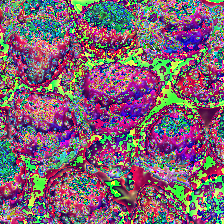

In [278]:
new_img_straw = transforms.ToPILImage()(img_straw_t)
new_img_straw

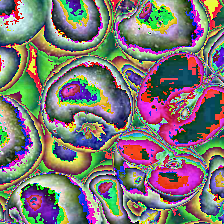

In [275]:
new_img_apple = transforms.ToPILImage()(img_apple_t)
new_img_apple

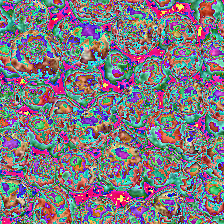

In [276]:
new_img_blueb = transforms.ToPILImage()(img_blueb_t)
new_img_blueb

In [254]:
batch_t = torch.stack([img_straw_t, img_apple_t, img_blueb_t])
batch_t.shape

torch.Size([3, 3, 224, 224])

Avg pixel value for all 3 channels by img.

In [274]:
for img in batch_t:
    print(f'{img.mean():9.4f}')

  -0.6473
   0.2011
  -0.3821


Get pixel value by channel.

In [285]:
for i, img in enumerate(batch_t):
    for j, c in enumerate(['red', 'green', 'blue']):
        print(f'Image {i}: {c:5} {img[j].mean():9.4f}')

Image 0: red      0.6225
Image 0: green   -1.3246
Image 0: blue    -1.2398
Image 1: red      0.1299
Image 1: green    0.9351
Image 1: blue    -0.4617
Image 2: red     -1.0166
Image 2: green   -0.4677
Image 2: blue     0.3380


2.

Build index and tokenize with a new text file. I'm using the Odyssey by Homer.

In [296]:
with open('data/p1ch4/odyssey.txt', encoding='utf8') as f:
    text_new = f.read()

In [298]:
word_list_new = sorted(set(clean_words(text_new)))
word2index_dict_new = {word: i for (i, word) in enumerate(word_list_new)}
len(word2index_dict_new)

9181

In [303]:
line_new = text_new.split('\n')[100]
line_new

'at the place now called Trapani, and introduced herself into her work'

In [305]:
word_t_new = torch.zeros(len(line_new), len(word2index_dict_new))
word_t_new.shape

torch.Size([69, 9181])

In [322]:
for i, word in enumerate(clean_words(line_new)):
    word_idx = word2index_dict_new[word]
    word_t_new[i, word_idx] = 1
    print(f'{i:4} {word_idx :4} {word}')

   0  949 at
   1 7919 the
   2 5949 place
   3 5465 now
   4 1515 called
   5 8171 trapani
   6  754 and
   7 4406 introduced
   8 3966 herself
   9 4400 into
  10 3936 her
  11 8876 work
